# I used Q-learning technique for this task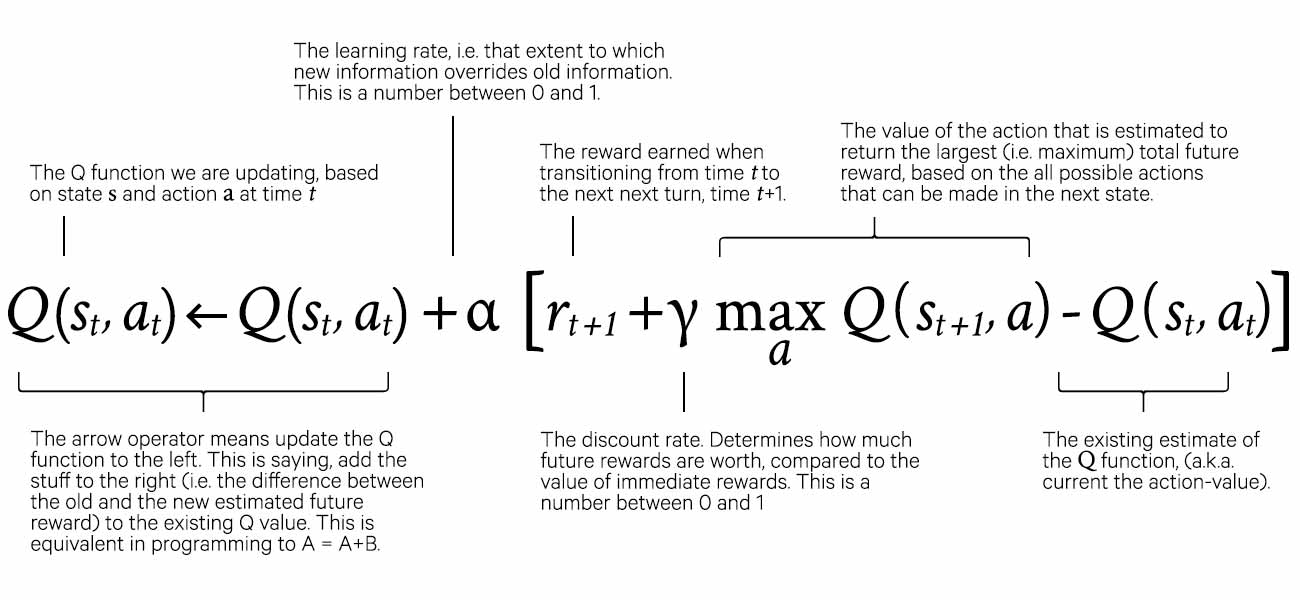

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt

class MyEnvironment:
    def __init__(self, environment_name: str, action = None, observation = None):

        self.environment_name = environment_name
        self.environment = gym.make(self.environment_name)
        self.action = action
        self.observation = observation
        if 'CartPole' in self.environment_name:
            self.n_bins = 20
            self.bins = [np.linspace(-4.8, 4.8, self.n_bins), np.linspace(-4, 4, self.n_bins),
                np.linspace(-0.418, 0.418, self.n_bins), np.linspace(-4, 4, self.n_bins)]

    def get_environment_name(self) -> str:
        return self.environment.unwrapped.spec.id

    def get_action_space(self):
        return self.environment.action_space

    def get_action_space_length(self):
        if 'CartPole' in self.environment_name:
            return 2
        return self.environment.action_space.n

    def get_observation_space(self):
        return self.environment.observation_space

    def get_observation_space_length(self):
        if 'CartPole' in self.environment_name:
            return [self.n_bins+1] * len(self.environment.observation_space.high)
        return [self.environment.horizon + 1]

    # Discretize the observation for CartPole.
    def set_observation(self, observation) -> None:
        self.observation = observation
        if 'CartPole' in self.environment_name:
            observation_index = []
            for i in range(len(self.get_observation_space().high)):
                observation_index.append(np.digitize(self.observation[i], self.bins[i]) - 1)
            self.observation = tuple(observation_index)

    def display_environment(self):
        plt.imshow(self.environment.render(mode = 'rgb_array'))

    def reset(self):
        return self.environment.reset()

    def step(self):
        return self.environment.step(self.action)

    def render(self):
        return self.environment.render()

    def close(self):
        self.environment.close()

In [3]:
import gym
import argparse
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as i_python_display

class Agent:
    def __init__(self, action_space: gym.spaces.Discrete, action_space_length,
        observation_space: gym.spaces.Discrete, observation_space_length,
            n_episodes: int, learning_rate: float, gamma: float):

        self.action_space = action_space
        self.action_space_length = action_space_length
        self.observation_space = observation_space
        self.observation_space_length = observation_space_length
        self.n_episodes = n_episodes
        self.epsilon = np.exp(-5 * np.linspace(0, 1, n_episodes))
        self.q_table = np.random.uniform(low = -2, high = 0, size = (self.observation_space_length + [self.action_space_length]))
        self.learning_rate = learning_rate
        self.gamma = gamma

    # Returns an action based on 'epsilon
    # greedy condition,' (returns a
    # uniformly sampled random action from
    # the action space if the random number
    # generated is less than epsilon, else,
    # the action that has the highest
    # Q-value in observation/ state)
    def act(self, observation: int, episode_number: int) -> int:

        if np.random.uniform(1.0, 0.0) < self.epsilon[episode_number]:
            return self.action_space.sample()
        return np.argmax(self.q_table[observation])

    # Estimates the optimal future Q-value
    # (the maximum Q-value in next
    # observation, updates the Q-table and
    # returns the change in Q-value)
    def update(self, observation: int, action: int, next_observation: int, reward: float) -> float:

        q_value = self.q_table[observation][action]
        next_q_value_estimate = np.max(self.q_table[next_observation])
        temporal_difference_target = reward + self.gamma * next_q_value_estimate
        self.q_table[observation][action] += self.learning_rate * (temporal_difference_target - q_value)
        return self.q_table[observation][action] - q_value



def plot_statistics(running_accuracy, running_delta):
    step_size = round(n_episodes/20)
    x = np.arange(1, n_episodes, step_size)
    markers = ["C8-","C20"]
    fig, (ax1, ax2) = plt.subplots(2, sharex = True)
    fig.suptitle('Performance vs Episode Number')
    ax1.plot(x, running_accuracy[1: -1: step_size], markers[0])
    ax1.set(ylabel = 'Accuracy')
    ax2.plot(x, running_delta[1: -1: step_size], markers[1])
    ax2.set(ylabel = 'Delta')
    plt.savefig('cartpole_q_learning.jpg')
    plt.show()



# CartPole actions are modelled as binary
# actions (left & right), and CartPole
# has discrete action space. The 'epsilon'
# value is used to balance 'Exploration'
# vs 'Exploitation.'
def main_loop():

    np.random.seed(111989)
    DISPLAY_FREQUENCY = 100
    environment = MyEnvironment('CartPole-v1')
    environment.reset()
    action_space = environment.get_action_space()
    action_space_length = environment.get_action_space_length()
    observation_space = environment.get_observation_space()
    observation_space_length = environment.get_observation_space_length()
    agent = Agent(action_space, action_space_length, observation_space, observation_space_length, n_episodes, learning_rate, gamma)
    environment.display_environment()
    running_length = 5
    running_delta, running_accuracy = [], []
    render_gym = True

    # Track the number of episodes completed
    # (episode_count), the number of actions
    # that yield maximum reward or successes
    # (optimal_actions), cumulative reward
    # and delta update of the Q-table.
    for episode_index in range(n_episodes):

        episode_count = 1
        optimal_actions = 0
        delta_update = []
        observation = environment.reset()
        environment.set_observation(observation)
        observation = environment.observation

        done = False
        while not done:
            if episode_index % DISPLAY_FREQUENCY == 0:
                if render_gym and ('CartPole' in environment.environment_name):
                    environment.display_environment()
                    i_python_display.clear_output(wait = True)
                    i_python_display.display(plt.gcf())

            # run episode
            action = agent.act(observation, episode_index)
            environment.action = action
            next_observation, reward, done, _ = environment.step()
            environment.set_observation(next_observation)
            next_observation = environment.observation
            delta_update.append(agent.update(observation, action, next_observation, reward))
            observation = next_observation
            optimal_actions += int(reward > 0.0)
            episode_count += 1

        running_delta.append(sum(delta_update).item())
        running_accuracy.append(optimal_actions/episode_count)
        print('episode = {}, epsilon = {}, cumulative delta = {}, accuracy = {} \n'.format(episode_index, agent.epsilon[episode_index], running_delta[episode_index], running_accuracy[-1]))
        if (episode_index >= n_episodes + running_length ) or (all([accuracy == 1.0 for accuracy in running_accuracy]) and all([delta < 0.0001 for delta in running_delta]) and episode_index >= running_length):
            break

    i_python_display.clear_output(wait = True)
    environment.close()
    plot_statistics(running_accuracy, running_delta)





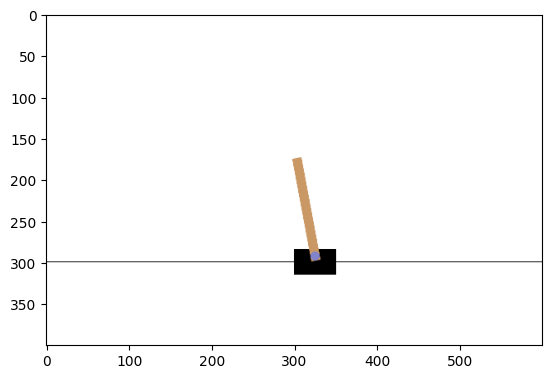

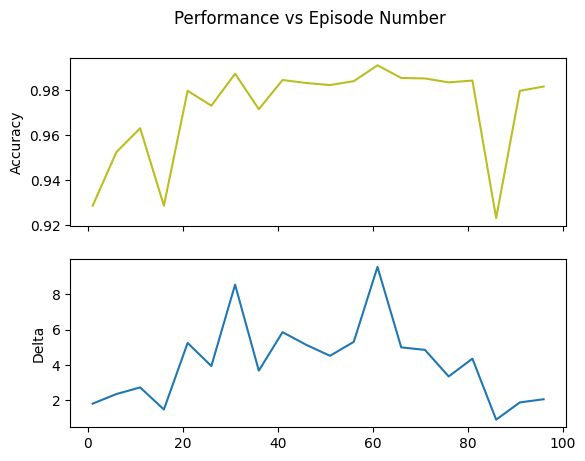

In [5]:
n_episodes = 100
learning_rate = 0.1
gamma = 0.95

main_loop()

#Let's try more episodes

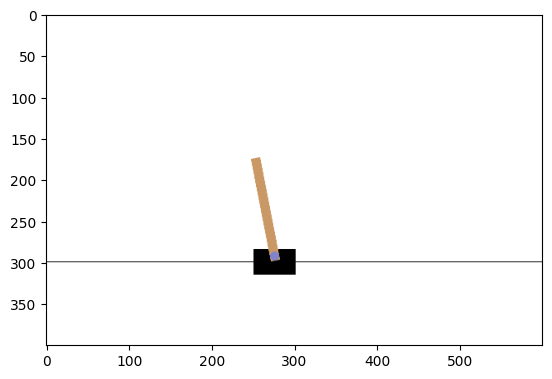

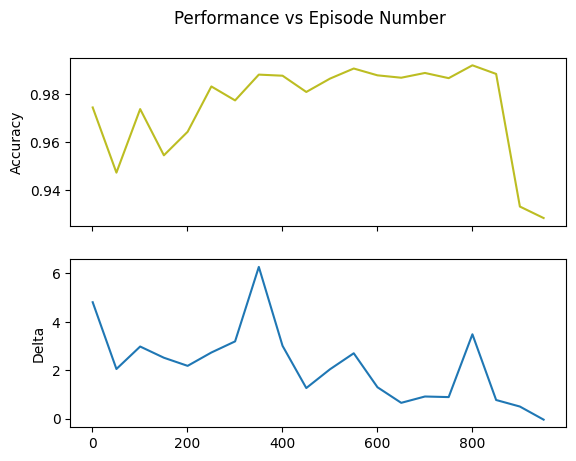

In [6]:
n_episodes = 1000
learning_rate = 0.1
gamma = 0.95

main_loop()

#As we can see, the model was successfully trained up to 800 iterations, then overfitting is observed

# 😊😊😊